In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
import cv2
from google.colab.patches import cv2_imshow
# For reproducibility
np.random.seed(42)

import fnmatch
import os
import pickle as pkl
import shutil

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

In [2]:
#Code adapted from : https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=TbRbQAYqPTci

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  9 17:04:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def resize_images(dir_path, resized_dir_path):
  Xtrain_img_list1 = sorted(glob.glob(f'{dir_path}/*.jpeg'))

  IMG_height = 224
  IMG_width = 224
  Xtrain_img_data = np.empty((len(Xtrain_img_list1), IMG_height, IMG_width, 3), dtype=np.float32)
  Xtrain_img_name=[None] * len(Xtrain_img_list1)
  print(len(Xtrain_img_data))
  print(len(Xtrain_img_name))
  ## read and convert to arrays
  for i, img_path in enumerate(Xtrain_img_list1):
    try:
      # print(i)    
      img = cv2.imread(img_path)   
      img_resized = cv2.resize(img, (IMG_width,IMG_height), interpolation = cv2.INTER_CUBIC)
      # save to numpy array
    
      Xtrain_img_data[i] = img_resized 
    
      Xtrain_img_name[i]=str(img_path.rsplit('.',1)[0].rsplit('/',1)[1])
      
      cv2.imwrite(f'{resized_dir_path}/{Xtrain_img_name[i]}_resized.png', Xtrain_img_data[i]) 

      if i in [1,1000,2000,3000,4000,5000,6000,7000,8000,8408]:
        print(i)

    except Exception:
      print(f'some error for image: {Xtrain_img_name[i]}')   

  return (Xtrain_img_data, Xtrain_img_name) 


In [ ]:
dir_path='/content/drive/MyDrive/GA/Capstone/train_4/train'
resized_dir_path='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'

In [ ]:
#do not run it again, resized images saved in the directory
#train resized images are in /content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg
Xtrain_img_data, Xtrain_img_name = resize_images(dir_path, resized_dir_path)

8415
8415
1
1000
2000
3000
4000
5000
6000
7000
8000
8408


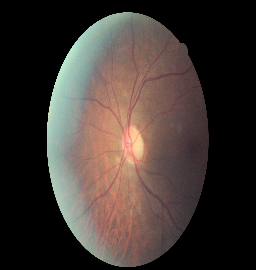

In [ ]:
cv2_imshow(img1)

In [ ]:
#dont run it again- the names list is saved in the directory

# read train labels csv
train_labels=pd.read_csv('/content/drive/MyDrive/GA/Capstone/trainLabels.csv')
train_labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
#dont run it again- the names list is saved in the directory

def get_label(image, train_labels):
  return(train_labels[train_labels['image']==image]['level'].values[0])

In [ ]:
#dont run it again- the labels are saved in the directory

#help from https://github.com/keras-team/keras/issues/14416

# label_list =[None] * len(fnmatch.filter(os.listdir('/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'), '*.png'))
# image_names=[None] * len(fnmatch.filter(os.listdir('/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'), '*.png'))

# for proot, directories, images in os.walk('/content/drive/MyDrive/GA/Capstone/train'):
#   # print(images)
#   i=0
#   for image in images:
#     # label_file = replace_file_extension(image_file, 'png', 'csv')
#     image_names[i]=str(image.rsplit('.',1)[0].rsplit('_',1)[0])
#     label_list[i]=get_label(image_names[i], train_labels)
#     i+=1

In [ ]:
#dont run it again- the names list is saved in the directory

# label_df=pd.DataFrame(image_names,columns=['image_id'])
# label_df['label']=label_list
# label_df.head(10)

,image_id,label
0,37569_right,0
1,37571_left,0
2,37571_right,0
3,37573_left,0
4,37573_right,0
5,37575_left,0
6,37575_right,0
7,37579_left,0
8,37579_right,0
9,37580_left,0


In [ ]:
label_df.shape

(28860, 2)

In [ ]:
#dont run it again- the names list is saved in the directory

# label_df['level']=label_df['label'].map( {0:'No DR', 1:'Mild DR',2:'Moderate DR',3:'Severe DR',4:'Proliferative DR'})

In [ ]:
#dont run it again- the names list is saved in the directory

# label_df.head()

,image_id,label,level
0,37569_right,0,No DR
1,37571_left,0,No DR
2,37571_right,0,No DR
3,37573_left,0,No DR
4,37573_right,0,No DR


In [ ]:
#dont run it again- the names list is saved in the directory

# label_df.sort_values(by='image_id', inplace=True)
# # label_df = label_df.reindex(index=order_by_index(label_df.index, index_natsorted(label_df['image_id'])))
# label_df.head()

,image_id,label,level
13933,10003_left,0,No DR
13934,10003_right,0,No DR
13935,10007_left,0,No DR
13936,10007_right,0,No DR
13937,10009_left,0,No DR


In [ ]:
#dont run it again- the names list is saved in the directory

# train_labels (~20k images) saved in '/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv'
# test labels saved in '/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv'

# label_df.to_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3.csv', index=False)


In [ ]:
# train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3.csv')
# print(train_label_df.shape)
# train_label_df.head(25)

(28860, 3)


,image_id,label,level
0,10003_left,0,No DR
1,10003_right,0,No DR
2,10007_left,0,No DR
3,10007_right,0,No DR
4,10009_left,0,No DR
5,10009_right,0,No DR
6,1000_left,0,No DR
7,1000_right,0,No DR
8,10010_left,0,No DR
9,10010_right,0,No DR


**Highly imbalanced classes**:

In [ ]:
train_label_df['label'].value_counts(normalize=True)

0    0.737318
2    0.149931
1    0.068468
3    0.024705
4    0.019577
Name: label, dtype: float64

In [ ]:
train_label_df['label'].value_counts()

0    21279
2     4327
1     1976
3      713
4      565
Name: label, dtype: int64

Creating a column for binary classification  
 (labels are 1 for class: 1,2,3,4)

In [ ]:
# train_label_df['label_b']=train_label_df['label'].map({0:0, 1:1,2:1,3:1,4:1})
# train_label_df.head(25)

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0
5,10009_right,0,No DR,0
6,1000_left,0,No DR,0
7,1000_right,0,No DR,0
8,10010_left,0,No DR,0
9,10010_right,0,No DR,0


In [ ]:
train_label_df['label_b'].value_counts(normalize=True)

0    0.737318
1    0.262682
Name: label_b, dtype: float64

In [ ]:
train_label_df['label_b'].value_counts()

0    21279
1     7581
Name: label_b, dtype: int64

The classes are still imbalanced but models may perform better with binary classification

In [ ]:
# train_label_df.to_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv', index=False)

In [ ]:
# test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels.csv')
# print(test_label_df.shape)
# test_label_df.head(25)

(3822, 3)


,image_id,label,level
0,29127_left,0,No DR
1,29127_right,0,No DR
2,29132_left,0,No DR
3,29132_right,0,No DR
4,29135_left,0,No DR
5,29135_right,0,No DR
6,29137_left,0,No DR
7,29137_right,0,No DR
8,29139_left,0,No DR
9,29139_right,0,No DR


In [ ]:
test_label_df['label'].value_counts(normalize=True)

0    0.725798
2    0.150968
1    0.072737
3    0.028781
4    0.021716
Name: label, dtype: float64

In [ ]:
# test_label_df['label_b']=test_label_df['label'].map({0:0, 1:1,2:1,3:1,4:1})
# test_label_df.head(25)

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0
5,29135_right,0,No DR,0
6,29137_left,0,No DR,0
7,29137_right,0,No DR,0
8,29139_left,0,No DR,0
9,29139_right,0,No DR,0


In [ ]:
# test_label_df.to_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv', index=False)
# # 

In [4]:
train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv')
train_label_df.head()

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0


In [ ]:
train_label_df['label'].value_counts()

0    21279
2     4327
1     1976
3      713
4      565
Name: label, dtype: int64

In [31]:
train_label_df['label_b'].value_counts()

0    21279
1     7581
Name: label_b, dtype: int64

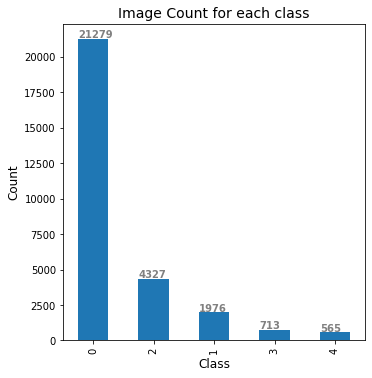

In [40]:
#Histogram for count of images per class

figure, ax=plt.subplots(figsize=(7,8))
  
ax=train_label_df['label'].value_counts().plot(kind='bar')
    
ax.set_title('Image Count for each class', size=14)
ax.set_xlabel('Class', size=12)
ax.set_ylabel('Count', size=12)
      
for i in ax.patches:
    if i.get_height() >0:
        plt.text(i.get_x()+0, i.get_height()+100,
                  str(round((i.get_height()), 2)),
                  fontsize = 10, fontweight ='bold',
                  color ='grey');
    else:
        pass
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.35);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/image_count.png');

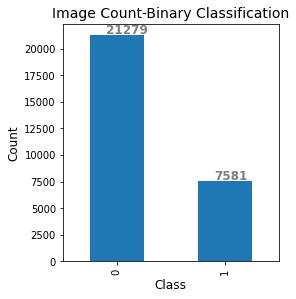

In [39]:
#Histogram for count of images per class- binary

figure, ax=plt.subplots(figsize=(5,6))
  
ax=train_label_df['label_b'].value_counts().plot(kind='bar')
    
ax.set_title('Image Count-Binary Classification', size=14)
ax.set_xlabel('Class', size=12)
ax.set_ylabel('Count', size=12)
      
for i in ax.patches:
    if i.get_height() >0:
        plt.text(i.get_x()+0.15, i.get_height()+100,
                  str(round((i.get_height()), 2)),
                  fontsize = 12, fontweight ='bold',
                  color ='grey');
    else:
        pass
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.35);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/image_count_binary.png');

In [20]:
test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv')
test_label_df.head()

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0


# Data Augmentation


### Sorting images of different classes in different folders  
(taking 4000 images of class 0 and all of the images for rest of the classes)  
Augmenting for classes that have less than 4000 images.

In [6]:
train_0=train_label_df[train_label_df['label']==0].copy()
train_0['image_id']=train_0['image_id'].map(lambda x: x+'_resized')
train_0=train_0[:4000]
train_0

In [7]:
train_1=train_label_df[train_label_df['label']==1].copy()
train_1['image_id']=train_1['image_id'].map(lambda x: x+'_resized')
train_1

In [8]:
train_2=train_label_df[train_label_df['label']==2].copy()
train_2['image_id']=train_2['image_id'].map(lambda x: x+'_resized')
train_2

In [9]:
train_3=train_label_df[train_label_df['label']==3].copy()
train_3['image_id']=train_3['image_id'].map(lambda x: x+'_resized')
train_3

In [10]:
train_4=train_label_df[train_label_df['label']==4].copy()
train_4['image_id']=train_4['image_id'].map(lambda x: x+'_resized')
train_4

In [11]:
train_0['image_id'].to_list();

In [12]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/0'

for file in train_0['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [13]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/1'

for file in train_1['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [14]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/3'

for file in train_3['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [15]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/4'

for file in train_4['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [16]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/2'

for file in train_2['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

The data is now sorted in 5 different folders.   
class 0 has 4000 images  
class 1 has 1976 images  
class 2 has 4327 images  
class 3 has 713 images  
class4 has 565 images  

In [35]:
train_da_df=pd.DataFrame.from_dict({'0':4000, '1':1976,'2':4327,'3':713,'4':565}, orient='index')
train_da_df.reset_index(inplace=True)
train_da_df.rename(columns={'index':'class', 0:'count'}, inplace=True)
train_da_df

,class,count
0,0,4000
1,1,1976
2,2,4327
3,3,713
4,4,565


In [36]:
total_da=train_da_df['count'].sum()
total_da


11581

In [37]:
train_da_df['count_normalized']=train_da_df['count']/total_da
train_da_df

,class,count,count_normalized
0,0,4000,0.345393
1,1,1976,0.170624
2,2,4327,0.373629
3,3,713,0.061566
4,4,565,0.048787


In [38]:
train_da_df.to_csv('/content/drive/MyDrive/GA/Capstone/data_aug_count.csv',index=False)

Baseline accuracy for this dataset is 0.37

### Augmenting images for class 1, 3 and 4

Augmenting images for class 1

In [ ]:
# Help from https://medium.com/analytics-vidhya/data-augmentation-techniques-using-opencv-657bcb9cc30b
#https://note.nkmk.me/en/python-opencv-numpy-rotate-flip/#:~:text=The%20OpenCV%20function%20that%20flips%20the%20image%20%28%3D,follows%3A%20flipcode%20%3C%200%3A%20flip%20vertically%20and%20horizontally

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/1'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/1'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))

for i, img in enumerate(img_list):  
  # image = tf.expand_dims(image, 0)  
  
  image=cv2.imread(img)
  img_name=str(img.rsplit('.',1)[0].rsplit('/',1)[1])

  #Brightening image
  bright=np.ones(image.shape, dtype='uint8') * 40
  bright_image=cv2.add(image, bright)
  cv2.imwrite(target_dir + "/"+img_name+"_bright.png", bright_image)
  
  #Flipping image
  flipped_image=cv2.flip(image, 3)
  cv2.imwrite(target_dir + "/"+img_name+"_flipped.png", flipped_image)

  # cv2_imshow(image)
  # print("")
  # cv2_imshow(bright_image)
  # print("")
  # cv2_imshow(flipped_image)
 


In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/1'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/1'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))
len(img_list)

5928

Augmenting images for class 3

In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/3'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/3'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))

for i, img in enumerate(img_list):  
  
  # image = tf.expand_dims(image, 0)  
  
  image=cv2.imread(img)
  img_name=str(img.rsplit('.',1)[0].rsplit('/',1)[1])

  #Increase brightness
  bright=np.ones(image.shape, dtype='uint8') * 40
  bright_image=cv2.add(image, bright)
  cv2.imwrite(target_dir + "/"+img_name+"_bright.png", bright_image)
  
  
  #Decrease brightness
  bright=np.ones(image.shape, dtype='uint8') * 40
  dark_image=cv2.subtract(image, bright)
  cv2.imwrite(target_dir + "/"+img_name+"_dark.png", dark_image)

  #Flipping image
  flipped_image=cv2.flip(image, 3)
  cv2.imwrite(target_dir + "/"+img_name+"_flipped.png", flipped_image)

  #Inverting image
  inverted_image=cv2.flip(image, -1)
  cv2.imwrite(target_dir + "/"+img_name+"_inverted.png", inverted_image)

  #Increasing brightness and Inverting image
  bright2=np.ones(image.shape, dtype='uint8') * 60
  bright_image2=cv2.add(image, bright2)
  inverted_image2=cv2.flip(bright_image2, -1)
  cv2.imwrite(target_dir + "/"+img_name+"_brghtinverted.png", inverted_image2)

  # cv2_imshow(image)
  # print("")
  # cv2_imshow(bright_image)
  # print("")
  # cv2_imshow(dark_image)
  # print("")
  # cv2_imshow(flipped_image)
  # print("")
  # cv2_imshow(inverted_image)
  # print("")
  # cv2_imshow(inverted_image2)
  

In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/3'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/3'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))
len(img_list)

4278

Augmenting images for class 4

In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/4'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/4'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))

for i, img in enumerate(img_list):  
 
  # image = tf.expand_dims(image, 0)  
  
  image=cv2.imread(img)
  img_name=str(img.rsplit('.',1)[0].rsplit('/',1)[1])

  #Increase brightness
  bright=np.ones(image.shape, dtype='uint8') * 40
  bright_image=cv2.add(image, bright)
  cv2.imwrite(target_dir + "/"+img_name+"_bright.png", bright_image)
  
  #Increase brightness2
  bright2=np.ones(image.shape, dtype='uint8') * 70
  bright_image2=cv2.add(image, bright2)
  cv2.imwrite(target_dir + "/"+img_name+"_bright2.png", bright_image2)


  #Decrease brightness
  bright=np.ones(image.shape, dtype='uint8') * 40
  dark_image=cv2.subtract(image, bright)
  cv2.imwrite(target_dir + "/"+img_name+"_dark.png", dark_image)

  #Flipping image
  flipped_image=cv2.flip(image, 3)
  cv2.imwrite(target_dir + "/"+img_name+"_flipped.png", flipped_image)

  #Inverting image
  inverted_image=cv2.flip(image, -1)
  cv2.imwrite(target_dir + "/"+img_name+"_inverted.png", inverted_image)

  #Increasing brightness and Inverting image
  bright3=np.ones(image.shape, dtype='uint8') * 60
  bright_image3=cv2.add(image, bright3)
  inverted_image2=cv2.flip(bright_image3, -1)
  cv2.imwrite(target_dir + "/"+img_name+"_brghtinverted.png", inverted_image2)

  #Decreasing brightness and Inverting image
  bright4=np.ones(image.shape, dtype='uint8') * 60
  dark_image2=cv2.subtract(image, bright4)
  inverted_image3=cv2.flip(dark_image2, -1)
  cv2.imwrite(target_dir + "/"+img_name+"_darkinverted.png", inverted_image3)


  # cv2_imshow(image)
  # print("")
  # cv2_imshow(bright_image)
  # print("")
  # cv2_imshow(bright_image2)
  # print("")
  # cv2_imshow(dark_image)
  # print("")
  # cv2_imshow(flipped_image)
  # print("")
  # cv2_imshow(inverted_image)
  # print("")
  # cv2_imshow(inverted_image2)
  # print("")
  # cv2_imshow(inverted_image3)
 
  

In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/4'
target_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation/4'
folder_len=len(source_dir)

img_list=sorted(glob.glob(f'{source_dir}/*.png'))
len(img_list)

4569

Updated no. of images for each class:  
class 0 has 4000 images  
class 1 has 5928 images  
class 2 has 4327 images  
class 3 has 4278 images  
class4 has 4569 images  

In [24]:
train_augd_df=pd.DataFrame.from_dict({'0':4000, '1':5928,'2':4327,'3':4278,'4':4569}, orient='index')
train_augd_df.reset_index(inplace=True)
train_augd_df.rename(columns={'index':'class', 0:'count'}, inplace=True)
train_augd_df

,class,count
0,0,4000
1,1,5928
2,2,4327
3,3,4278
4,4,4569


In [25]:
total=train_augd_df['count'].sum()
total


23102

In [26]:
train_augd_df['count_normalized']=train_augd_df['count']/total
train_augd_df

,class,count,count_normalized
0,0,4000,0.173145
1,1,5928,0.256601
2,2,4327,0.187300
3,3,4278,0.185179
4,4,4569,0.197775


In [27]:
train_augd_df.to_csv('/content/drive/MyDrive/GA/Capstone/augmented_data_count.csv',index=False)

Baseline accuracy for this dataset is 0.26

# Sorting 500 images of different classes in different folders  
(taking 500 images of each class, idea is to not augment any data but reduce the data size to have balanced classes)  

In [ ]:
train_0=train_label_df[train_label_df['label']==0].copy()
train_0['image_id']=train_0['image_id'].map(lambda x: x+'_resized')
train_0=train_0[:500]
train_0

,image_id,label,level,label_b
0,10003_left_resized,0,No DR,0
1,10003_right_resized,0,No DR,0
2,10007_left_resized,0,No DR,0
3,10007_right_resized,0,No DR,0
4,10009_left_resized,0,No DR,0
...,...,...,...,...
679,10772_right_resized,0,No DR,0
680,10773_left_resized,0,No DR,0
681,10773_right_resized,0,No DR,0
682,10777_left_resized,0,No DR,0


In [ ]:
train_1=train_label_df[train_label_df['label']==1].copy()
train_1['image_id']=train_1['image_id'].map(lambda x: x+'_resized')
train_1=train_1[:500]
train_1

,image_id,label,level,label_b
26,10030_left_resized,1,Mild DR,1
27,10030_right_resized,1,Mild DR,1
64,10085_left_resized,1,Mild DR,1
65,10085_right_resized,1,Mild DR,1
123,10150_right_resized,1,Mild DR,1
...,...,...,...,...
6924,1785_left_resized,1,Mild DR,1
6933,17868_right_resized,1,Mild DR,1
6942,17873_left_resized,1,Mild DR,1
6943,17873_right_resized,1,Mild DR,1


In [ ]:
train_2=train_label_df[train_label_df['label']==2].copy()
train_2['image_id']=train_2['image_id'].map(lambda x: x+'_resized')
train_2=train_2[:500]
train_2

,image_id,label,level,label_b
25,1002_right_resized,2,Moderate DR,1
36,10043_left_resized,2,Moderate DR,1
37,10043_right_resized,2,Moderate DR,1
82,10109_left_resized,2,Moderate DR,1
83,10109_right_resized,2,Moderate DR,1
...,...,...,...,...
3103,13584_right_resized,2,Moderate DR,1
3104,13585_left_resized,2,Moderate DR,1
3105,13585_right_resized,2,Moderate DR,1
3106,13588_left_resized,2,Moderate DR,1


In [ ]:
train_3=train_label_df[train_label_df['label']==3].copy()
train_3['image_id']=train_3['image_id'].map(lambda x: x+'_resized')
train_3=train_3[:500]
train_3

,image_id,label,level,label_b
24,1002_left_resized,3,Severe DR,1
40,10047_left_resized,3,Severe DR,1
66,1008_left_resized,3,Severe DR,1
67,1008_right_resized,3,Severe DR,1
96,10125_left_resized,3,Severe DR,1
...,...,...,...,...
18786,36740_left_resized,3,Severe DR,1
18787,36740_right_resized,3,Severe DR,1
18817,36767_right_resized,3,Severe DR,1
18853,36812_right_resized,3,Severe DR,1


In [ ]:
train_4=train_label_df[train_label_df['label']==4].copy()
train_4['image_id']=train_4['image_id'].map(lambda x: x+'_resized')
train_4=train_4[:500]
train_4

,image_id,label,level,label_b
16,10017_left_resized,4,Proliferative DR,1
17,10017_right_resized,4,Proliferative DR,1
41,10047_right_resized,4,Proliferative DR,1
169,10193_right_resized,4,Proliferative DR,1
280,10312_left_resized,4,Proliferative DR,1
...,...,...,...,...
24247,43141_left_resized,4,Proliferative DR,1
24248,43141_right_resized,4,Proliferative DR,1
24315,43199_left_resized,4,Proliferative DR,1
24316,43199_right_resized,4,Proliferative DR,1


In [ ]:
train_0['image_id'].to_list();

In [ ]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_500count/0'

for file in train_0['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [ ]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_500count/1'

for file in train_1['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [ ]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_500count/2'

for file in train_2['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [ ]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_500count/3'

for file in train_3['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [ ]:
source_dir='/content/drive/MyDrive/GA/Capstone/train/train_2_reshapedImg'
target_dir='/content/drive/MyDrive/GA/Capstone/train_500count/4'

for file in train_4['image_id'].to_list():
  shutil.copy2(f'{source_dir}/{file}.png', target_dir)

In [ ]:

source_dir='/content/drive/MyDrive/GA/Capstone/train_500count/0'
img_list=sorted(glob.glob(f'{source_dir}/*.png'))
print(f'class0: {len(img_list)}')
source_dir='/content/drive/MyDrive/GA/Capstone/train_500count/1'
img_list=sorted(glob.glob(f'{source_dir}/*.png'))
print(f'class1: {len(img_list)}')
source_dir='/content/drive/MyDrive/GA/Capstone/train_500count/2'
img_list=sorted(glob.glob(f'{source_dir}/*.png'))
print(f'class2: {len(img_list)}')
source_dir='/content/drive/MyDrive/GA/Capstone/train_500count/3'
img_list=sorted(glob.glob(f'{source_dir}/*.png'))
print(f'class3: {len(img_list)}')
source_dir='/content/drive/MyDrive/GA/Capstone/train_500count/4'
img_list=sorted(glob.glob(f'{source_dir}/*.png'))
print(f'class4: {len(img_list)}')

class0: 500
class1: 500
class2: 500
class3: 500
class4: 500


The data is now sorted in 5 different folders and have equal no. of images: 500


In [28]:
train_sd_df=pd.DataFrame.from_dict({'0':500, '1':500,'2':500,'3':500,'4':500}, orient='index')
train_sd_df.reset_index(inplace=True)
train_sd_df.rename(columns={'index':'class', 0:'count'}, inplace=True)
train_sd_df

,class,count
0,0,500
1,1,500
2,2,500
3,3,500
4,4,500


In [29]:
total_sd=train_sd_df['count'].sum()
total_sd


2500

In [33]:
train_sd_df['count_normalized']=train_sd_df['count']/total_sd
train_sd_df

,class,count,count_normalized
0,0,500,0.2
1,1,500,0.2
2,2,500,0.2
3,3,500,0.2
4,4,500,0.2


In [34]:
train_sd_df.to_csv('/content/drive/MyDrive/GA/Capstone/small500_data_count.csv',index=False)

Baseline accuracy for this dataset is 0.2